## Setup

In [282]:
# imports
import cv2 
import glob 
import json 
import os
import numpy as np 
import random
import matplotlib.pyplot as plt

In [504]:
# functions to read a folder of images 

def read_images_to_array(folder_path):

  image_array = []
  # Get a sorted list of filenames
  filenames = sorted(os.listdir(folder_path))
  for filename in filenames:
    if filename.endswith(".jpg") or filename.endswith(".png"):
      img_path = os.path.join(folder_path, filename)
      img = cv2.imread(img_path)

      if img is not None:
        image_array.append(img)

  return image_array

# function to split image into 2 catgories (one mask and one raw) 

def split_images(image_array): 

    red_region_images = []
    raw_images = [] 

    for image in image_array:
        if image[25,100].sum() == 255*3 :
            red_region_images.append(image)
        else: 
            raw_images.append(image) 
            
    return red_region_images, raw_images

# function to crop out the noise

def crop_raw_images(image_array): 
    
    cropped_images = [] 
    
    for i in range(len(image_array)): 
        
        image = image_array[i]
        
        mask = np.zeros(image.shape, dtype=np.uint8)
        mask = cv2.circle(mask, (320, 240), 200, (255,255,255), -1)

        res = cv2.bitwise_and(image, mask)
        res[mask==0] = 255
        
        cropped_images.append(res)

    return cropped_images

# function to create binary masks 

def create_binary_masks(image_array):
    binary_masks = []
    
    for image in image_array:
        # Ensure image is in BGR format (convert if necessary)
        if image.ndim == 2:
            # Convert grayscale to BGR color (assuming gray image)
            image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        elif image.shape[2] != 3:
            raise ValueError("Input image must have 3 channels (BGR format).")
        else:
            image_color = image
        
        # Convert BGR to HSV
        hsv = cv2.cvtColor(image_color, cv2.COLOR_BGR2HSV)

        # Define lower and upper bounds for red color in HSV
        lower_red = np.array([0, 115, 115])
        upper_red = np.array([255, 255, 255])

        # Create mask using inRange function
        mask = cv2.inRange(hsv, lower_red, upper_red)

        # Apply bitwise AND operation using color image
        res = cv2.bitwise_and(image_color, image_color, mask=mask)
        
        binary_masks.append(mask)
        
    return binary_masks

# function to resize binary masks 

def crop_masks(image_array):
    cropped_masks = []

    for image in image_array:
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        mask = cv2.circle(mask, (250, 257), 135, (255, 255, 255), -1)

        if image.shape[:2] != mask.shape:
            raise ValueError("Image and mask dimensions do not match.")

        res = cv2.bitwise_and(image, image, mask=mask)
        res[mask == 0] = 255

        cropped_masks.append(res)

    return cropped_masks

# this function resizes the binary masks to match the size of the image 
def resize_binary_masks(image_array): 
    
    resized_binary_masks = []
    
    for image in image_array: 
        
        # crop 
        y=0
        x=0
        h=480
        w=640
        
        cropped_image = image[y:y+h, x:x+w]
        
        padding = 70 
        
        padded_img = cv2.copyMakeBorder(cropped_image, 0, 0, padding, padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])
        resized_binary_masks.append(padded_img) 
    
    return resized_binary_masks

# instead of resizing the masks, we could resize the raw image, might be more accurate

def resize_raw_images(image_array): 
    
    resized_raw_images = []
    
    for image in image_array: 
        
        # crop 
        x=0
        y=0
        h=480
        w=500
        
        cropped_image = image[y:y+h, x:x+w]
        
        resized_raw_images.append(cropped_image)
        
    return resized_raw_images

In [505]:
# this function is used to crop both sides of the image 

def double_crop(image_array): 
    
    cropped_images = []
    
    for image in image_array: 
        
        # this is crop for each side (totalCrop/2) 
        cropped_image = image[0:515, 70:570]
        
        cropped_images.append(cropped_image)
    
    return cropped_images

def zoom_at(image_array, zoom, coord=None):
    """
    Simple image zooming without boundary checking.
    Centered at "coord", if given, else the image center.

    img: numpy.ndarray of shape (h,w,:)
    zoom: float
    coord: (float, float)
    """
    
    zoomed_array = []
    
    for img in image_array: 
        

        # Translate to zoomed coordinates
        h, w, _ = [ zoom * i for i in img.shape ]

        if coord is None: cx, cy = w/2, h/2
        else: cx, cy = [ zoom*c for c in coord ]

        img = cv2.resize( img, (0, 0), fx=zoom, fy=zoom)
        img = img[ int(round(cy - h/zoom * .5)) : int(round(cy + h/zoom * .5)),
                   int(round(cx - w/zoom * .5)) : int(round(cx + w/zoom * .5)),
                   : ]
        zoomed_array.append(img)
    
    return zoomed_array
        

In [506]:
# get the folder of images 
folder_path = "./data/training_images"
images = read_images_to_array(folder_path)

# apply all the functions
image_masks, image_raw = split_images(images)
image_masks = zoom_at(image_masks, 1.4285, coord=None) 
image_raw = crop_raw_images(image_raw)

red_region = image_masks
# image_masks = resize_binary_masks(image_masks)
image_raw = double_crop(image_raw)
# image_masks = crop_masks(image_masks)

red_region = convert_BGR(red_region)
image_masks = create_binary_masks(image_masks)

In [507]:
image_masks = np.array(image_masks) 
image_raw = np.array(image_raw) 

print(image_masks.shape)
print(image_raw.shape)

(154, 515, 500)
(154, 480, 500, 3)


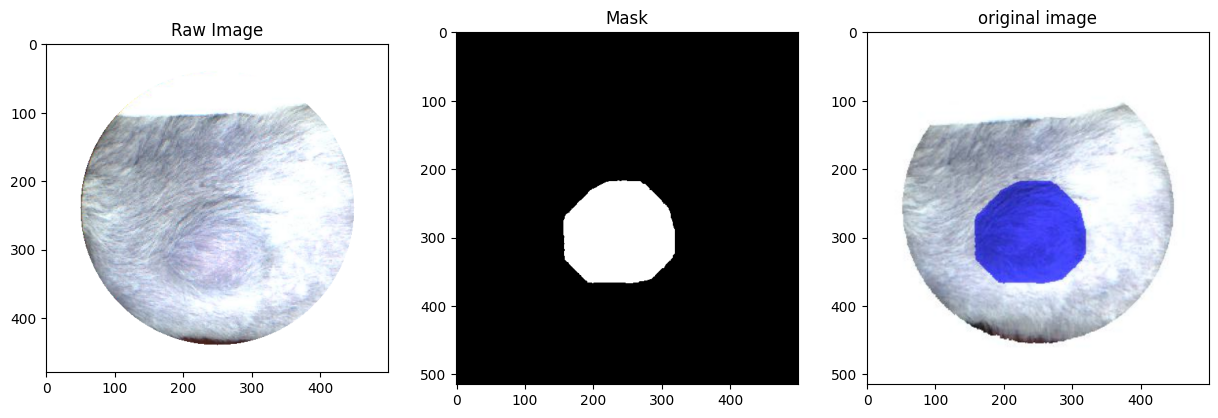

In [492]:
# now see if it worked 
rand = random.randint(0, len(image_raw)-1)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# len raw image: 400
# len mask: 280


ax[0].imshow(image_raw[rand]) 
ax[0].set_title("Raw Image") 

ax[1].imshow(image_masks[rand], cmap="gray")
ax[1].set_title("Mask")

ax[2].imshow(red_region[rand])
ax[2].set_title("original image")

plt.show()

In [367]:
# Check if the selected mask image is already grayscale
if len(image_masks[rand].shape) == 2:
    gray = image_masks[rand]
else:
    gray = cv2.cvtColor(image_masks[rand], cv2.COLOR_BGR2GRAY)

_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
contours = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]

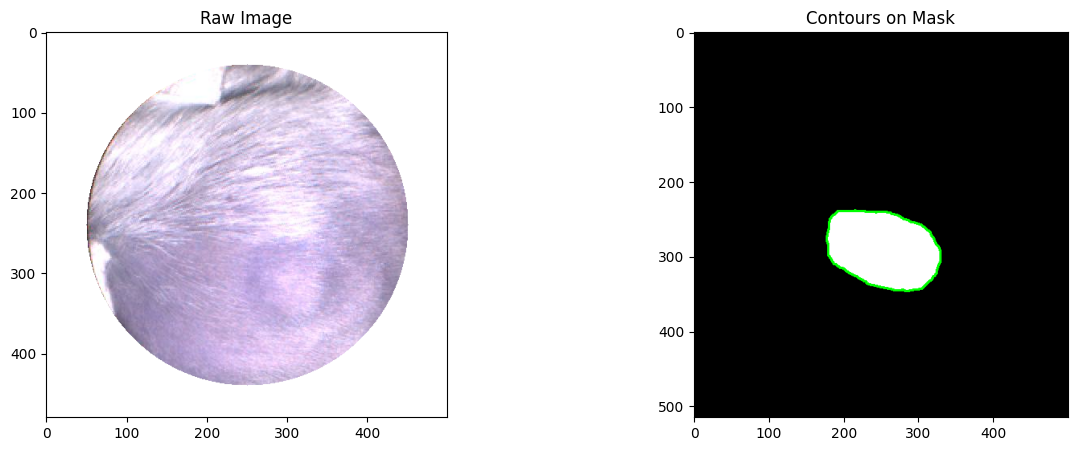

In [464]:
# Display the image and contours for verification
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].imshow(image_raw[rand])
ax[0].set_title("Raw Image")

# Draw contours on the mask image for visualization
contour_img = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)

ax[1].imshow(contour_img)
ax[1].set_title("Contours on Mask")

plt.show()

In [465]:
 for contour in contours:
    bbox = cv2.boundingRect(contour)
    area = cv2.contourArea(contour)
    segmentation = contour.flatten().tolist()

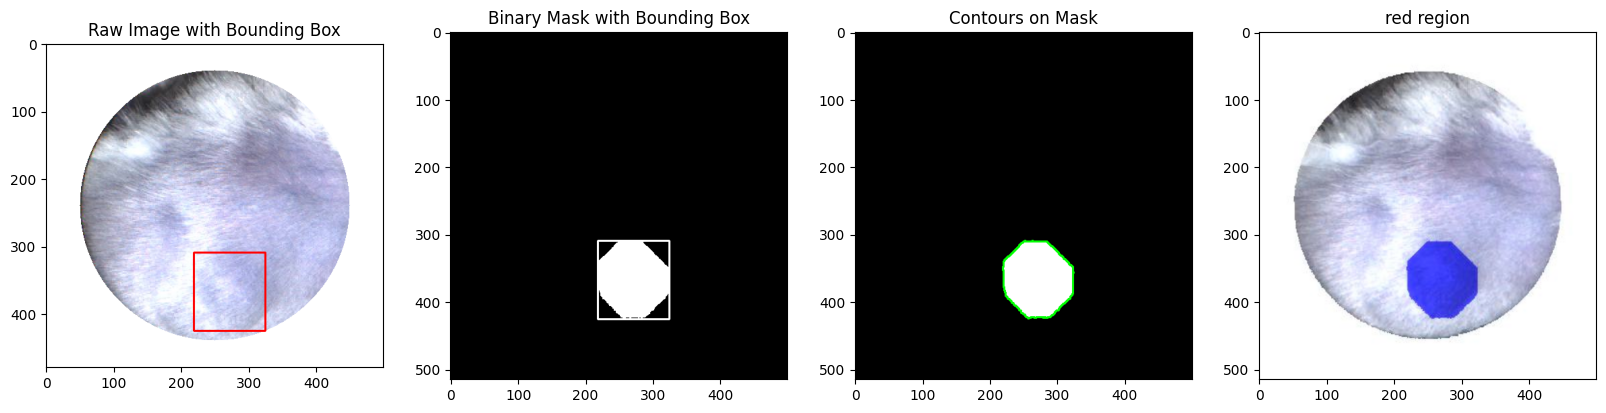

In [502]:
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Assuming image_raw and image_masks are your image data lists
rand = random.randint(0, len(image_raw) - 1)

# Check if the selected mask image is already grayscale
if len(image_masks[rand].shape) == 2:
    gray = image_masks[rand]
else:
    gray = cv2.cvtColor(image_masks[rand], cv2.COLOR_BGR2GRAY)

_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
contours = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]

# Find the bounding box for the first contour
x, y, w, h = cv2.boundingRect(contours[0])

# Draw the bounding box on the raw image
bbox_image = image_raw[rand].copy()
cv2.rectangle(bbox_image, (x, y), (x + w, y + h), (255, 0, 0), 2)

# Draw the bounding box on the binary mask image
bbox_mask = gray.copy()
cv2.rectangle(bbox_mask, (x, y), (x + w, y + h), (255, 0, 0), 2)

# Display the images for verification
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

ax[0].imshow(bbox_image)
ax[0].set_title("Raw Image with Bounding Box")

ax[1].imshow(bbox_mask, cmap='gray')
ax[1].set_title("Binary Mask with Bounding Box")

# Draw contours on the mask image for visualization
contour_img = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)

ax[2].imshow(contour_img)
ax[2].set_title("Contours on Mask")

ax[3].imshow(red_region[rand]) 
ax[3].set_title("red region")

plt.show()


## Now apply the contor and save it for all images